Library


In [37]:
import librosa
import numpy as np
import pandas as pd
from typing import Tuple
import joblib
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

Konstanta


In [38]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

dir_data_xc = MAIN_PATH+ r"\Dataset\xeno-canto"

# Pra-Pemrosesan


Function


In [39]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

Function Utama


In [40]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

# Ekstraksi Fitur


Function


In [41]:
def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

# Fitting


Load Scaler


In [42]:
scl = joblib.load(f"{MAIN_PATH}/Model/p_scaler.pkl")

Squeze


In [43]:
def normalisasi(X):
    # X = np.array(X)
    # X = X.flatten().reshape(1, -1)
    X = scl.transform(X)
    return X

# Visualize


Function


In [44]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='green', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Model


Load


In [45]:
model = joblib.load(f"{MAIN_PATH}/Model/p_lgbm.pkl")

# Main Process


In [48]:
def main_pipeline(path):
    result = []

    segments = prapemrosesan(path)
    for i, segment in enumerate(segments):
        start_time = round(i * 0.5, 2)
        end_time = round(start_time + 1.0, 2)
        timestamp = [start_time, end_time]

        rms = get_rms(segment)
        flatness = get_spectral_flatness(segment)
        # mfcc = get_mfcc(segment)
        # mfcc = normalisasi(mfcc)
        label = model.predict([[rms, flatness]])

        result.append({
            "name": path.split("/")[-1],
            "timestamp": timestamp,
            "label": label
        })

    return result

Contoh 1


In [49]:
audio_1 = dir_data_xc+r"\19655.mp3"
result_1 = main_pipeline(audio_1)

list_label_1 = [data["timestamp"] for data in result_1 if data["label"] == 0]
list_label_1

[]

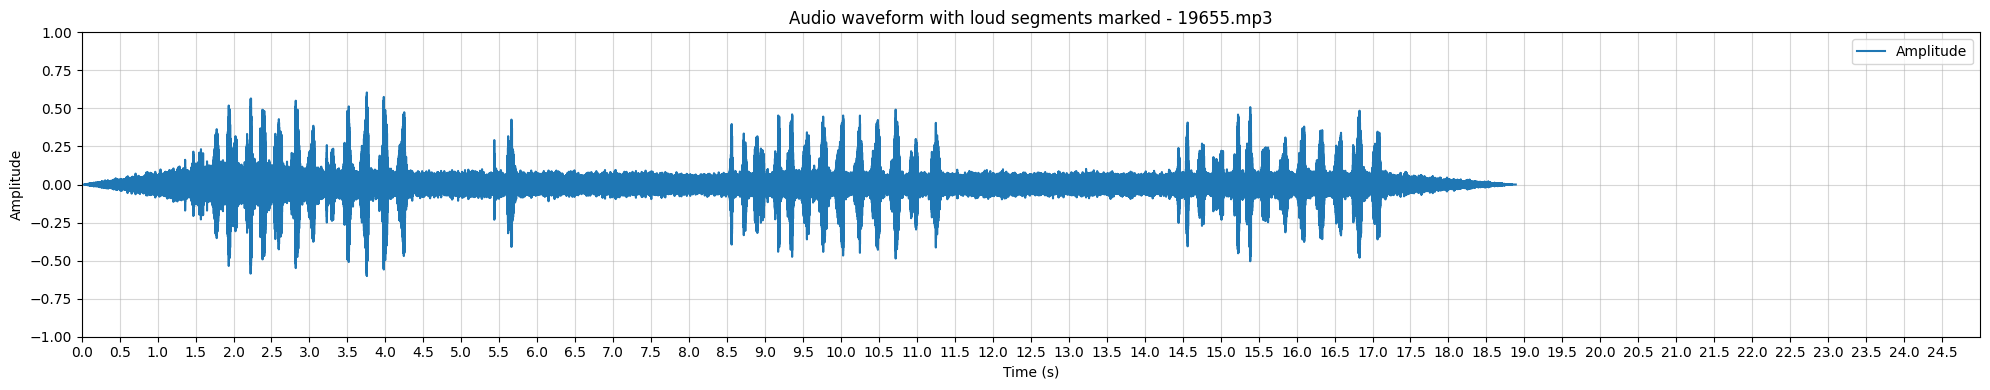

In [50]:
load_and_plot(audio_1, list_label_1, 25)

Loop


151761.mp3, []


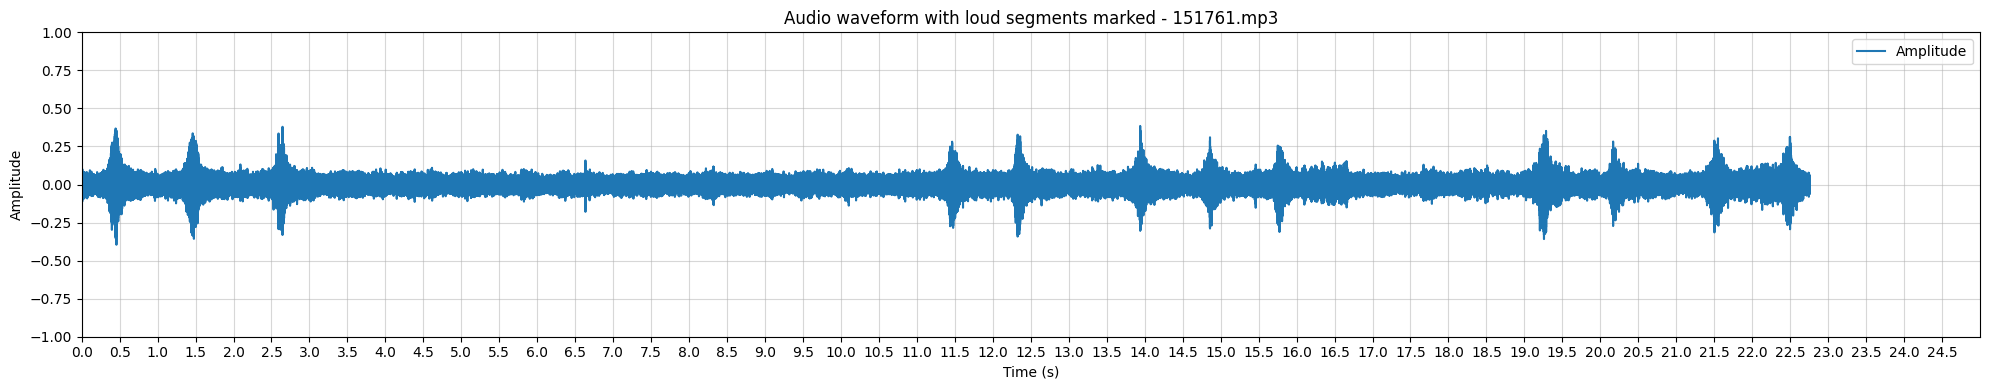

169538.mp3, []


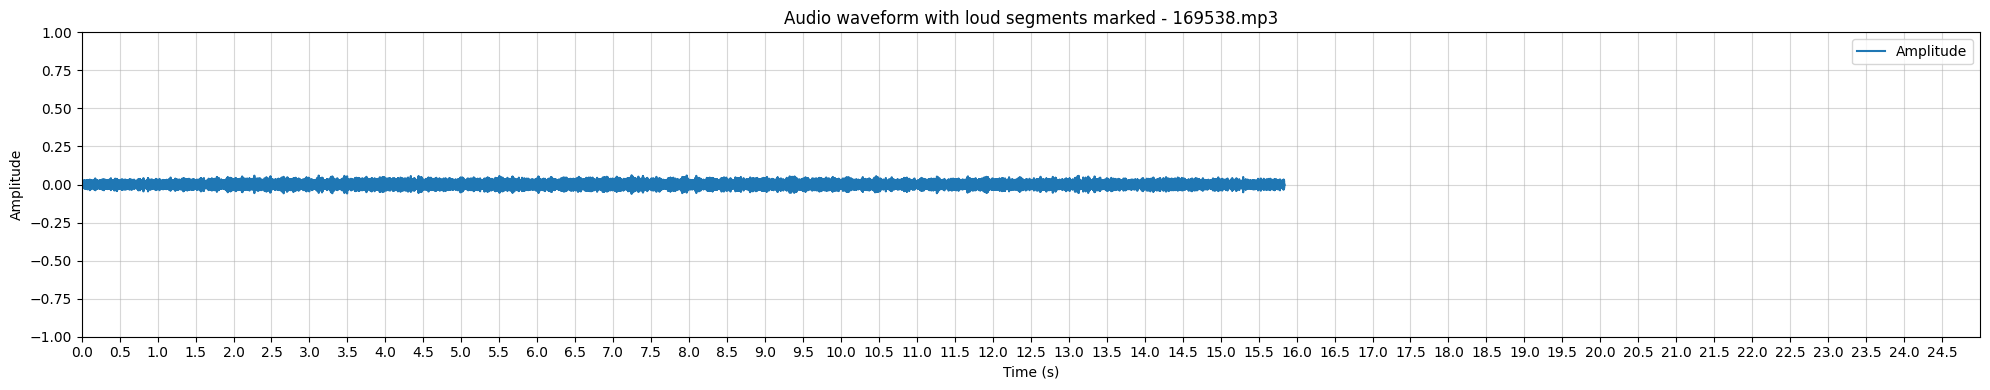

193835.mp3, []


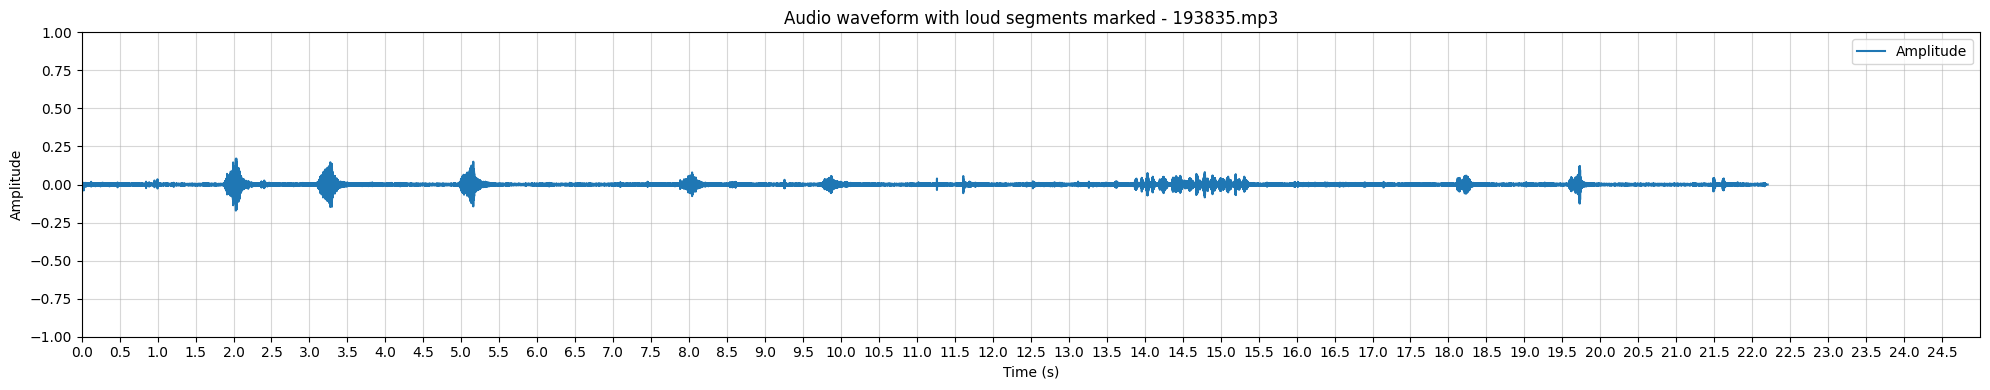

19655.mp3, []


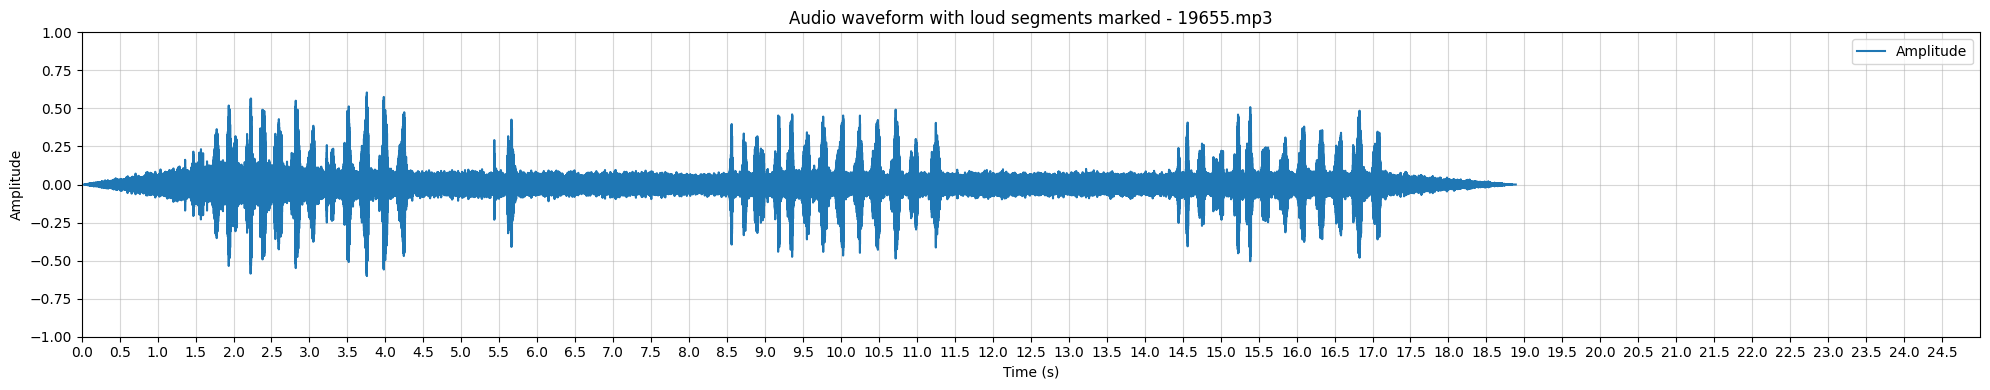

198426.mp3, []


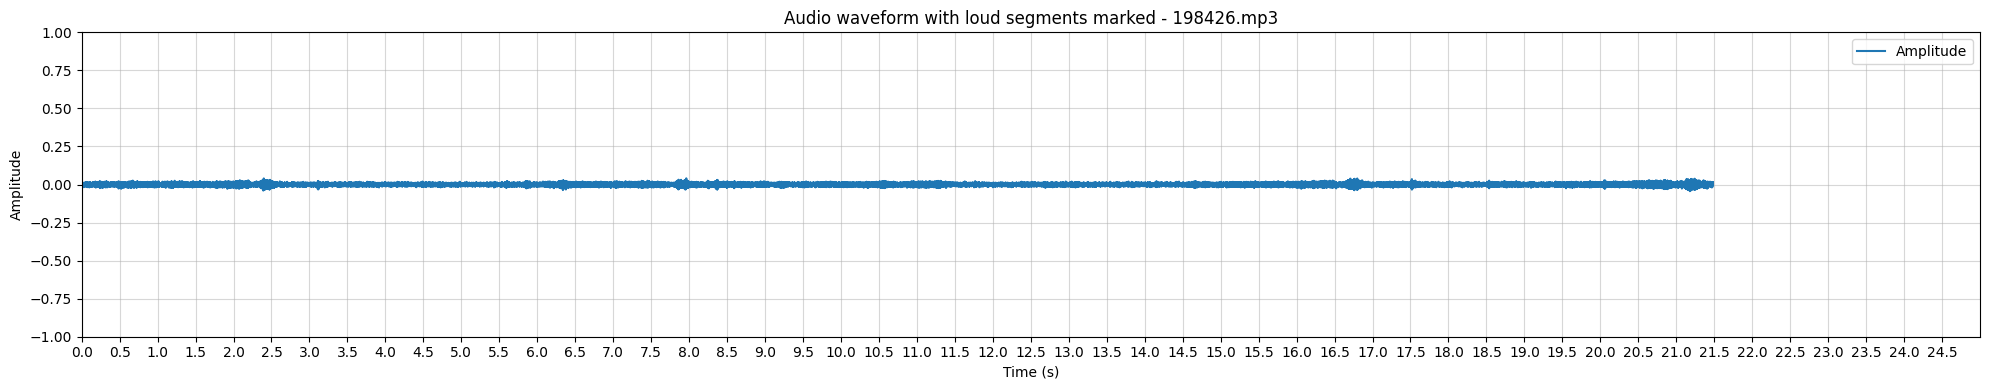

204334.mp3, []


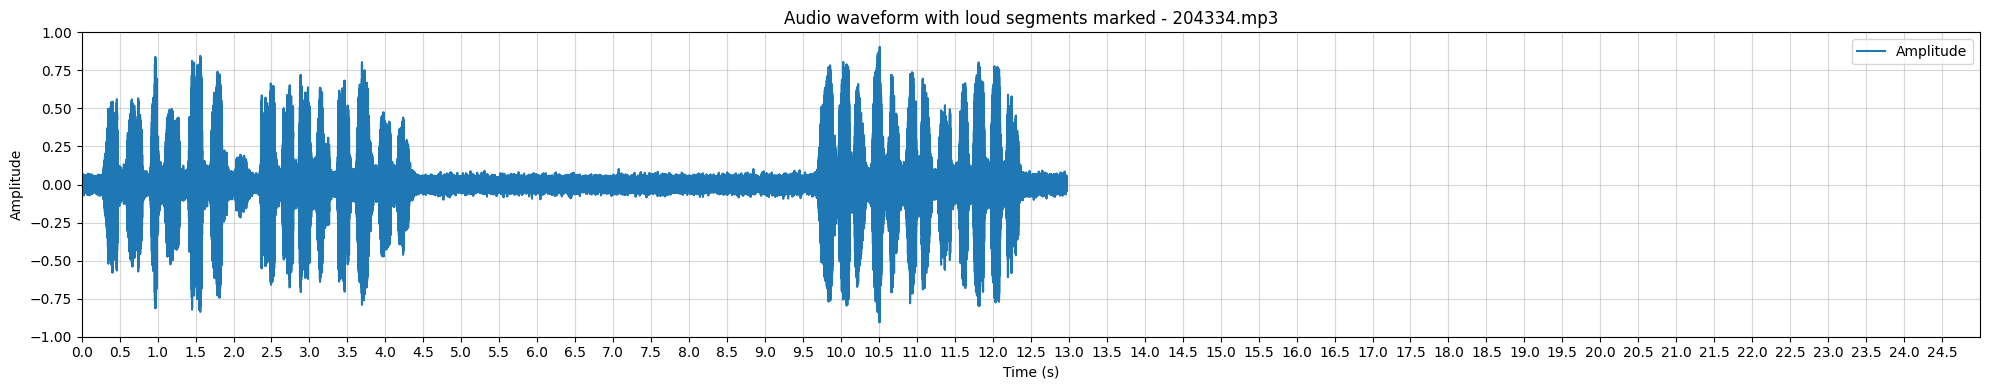

215401.mp3, []


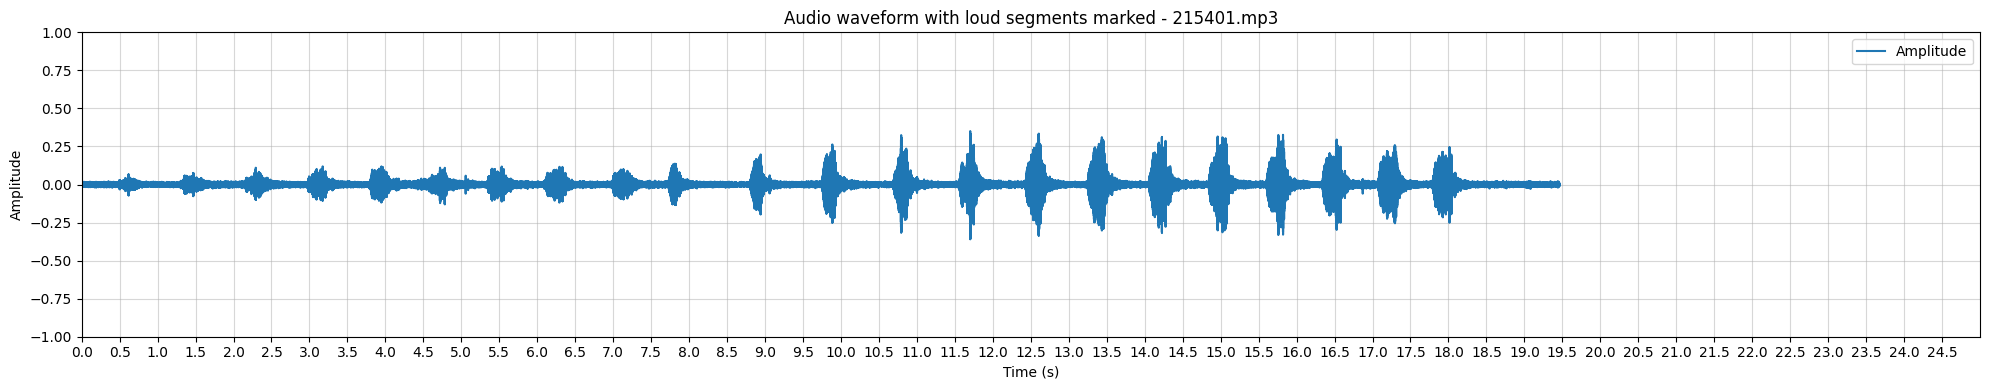

279210.mp3, []


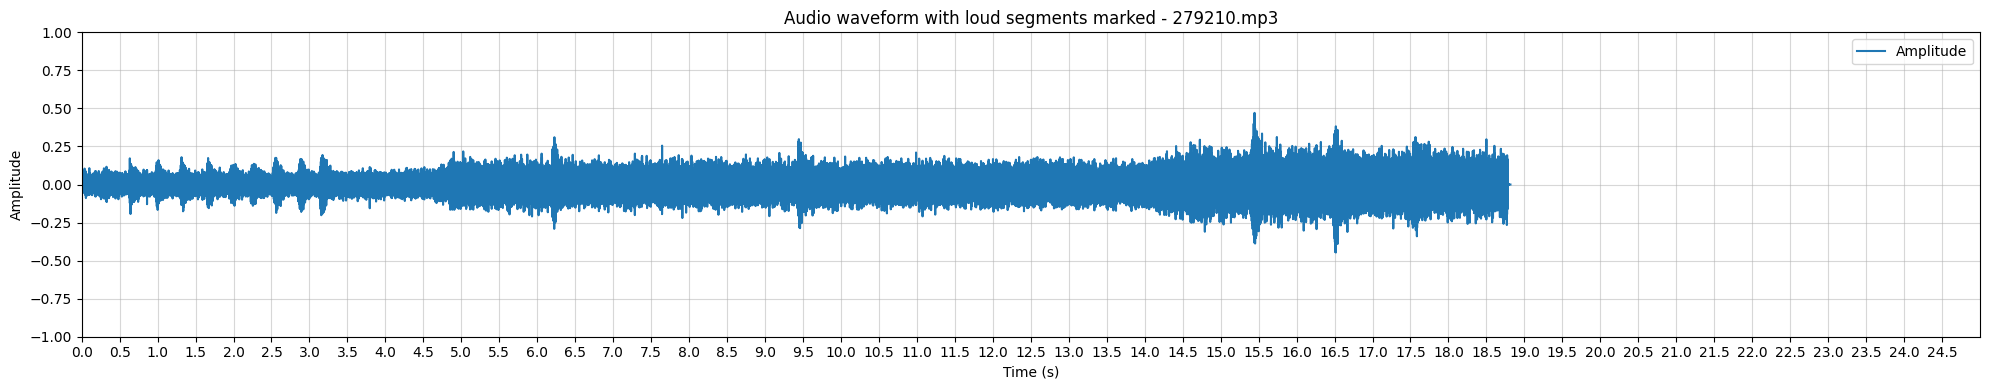

282469.mp3, []


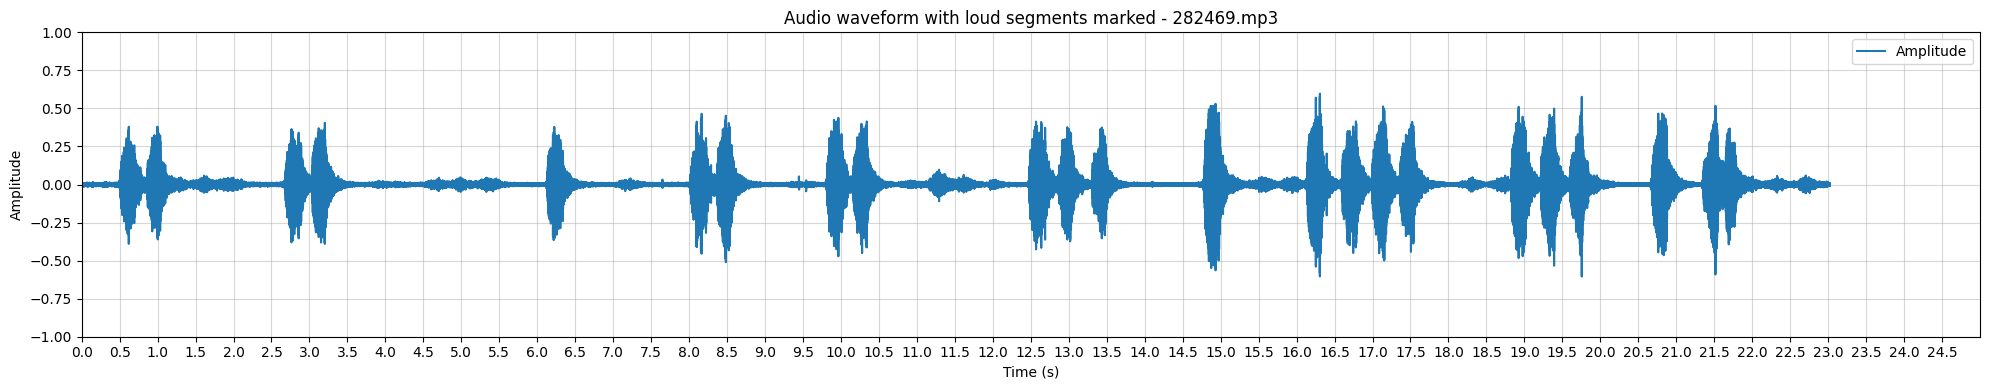

282506.mp3, []


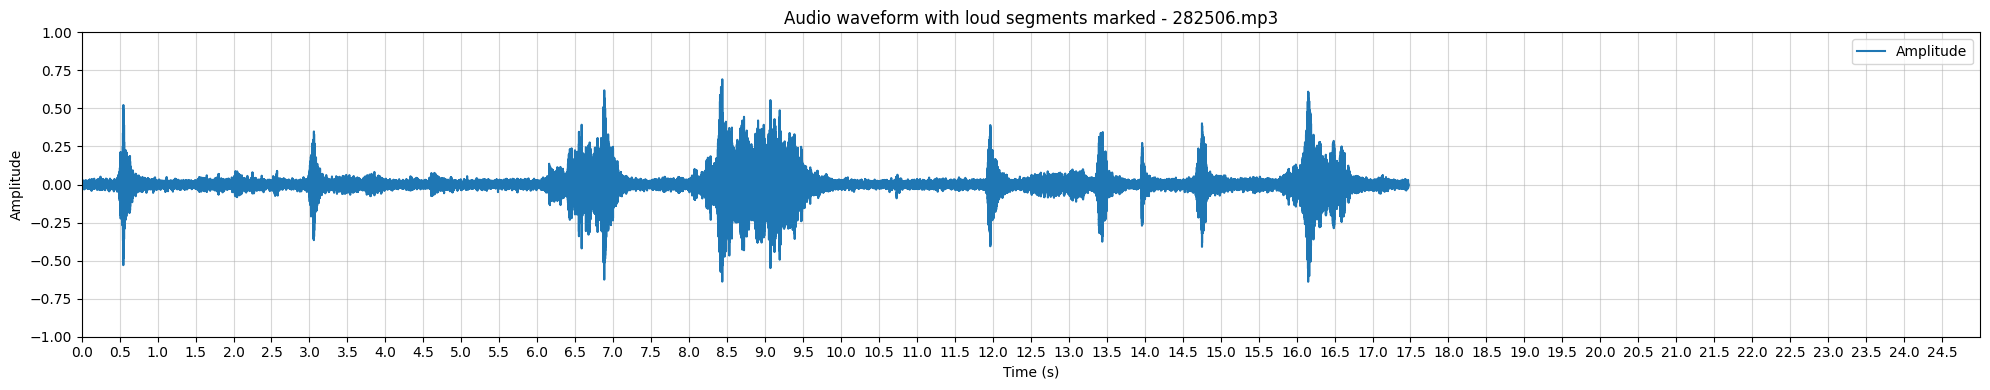

359523.mp3, []


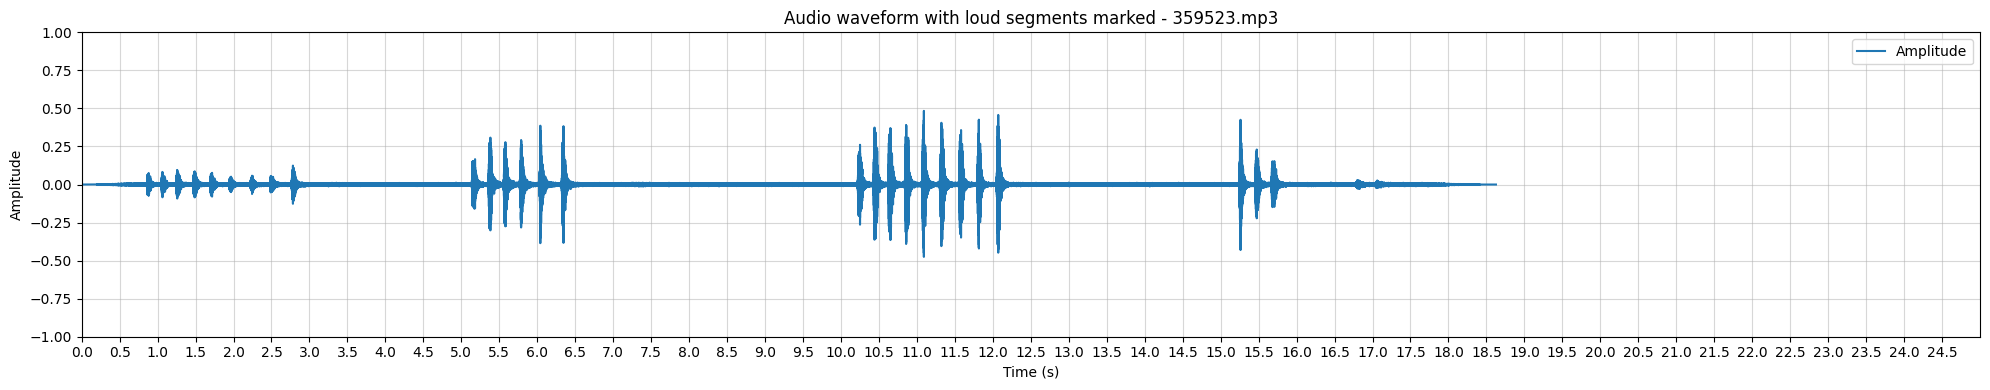

359552.mp3, []


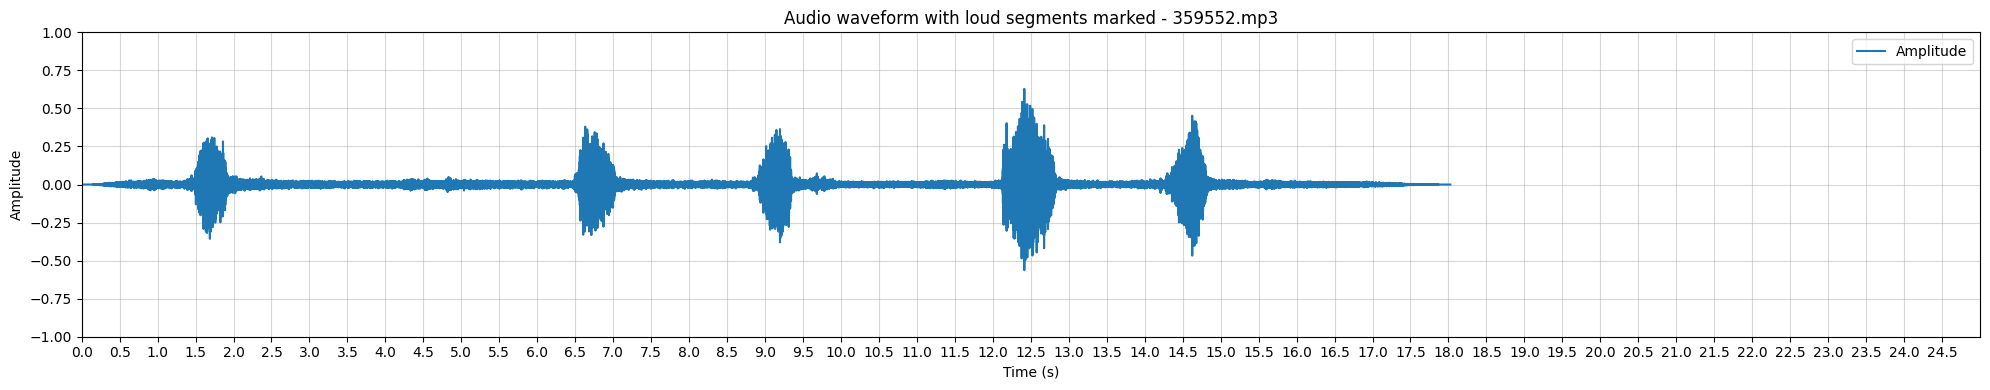

359595.mp3, []


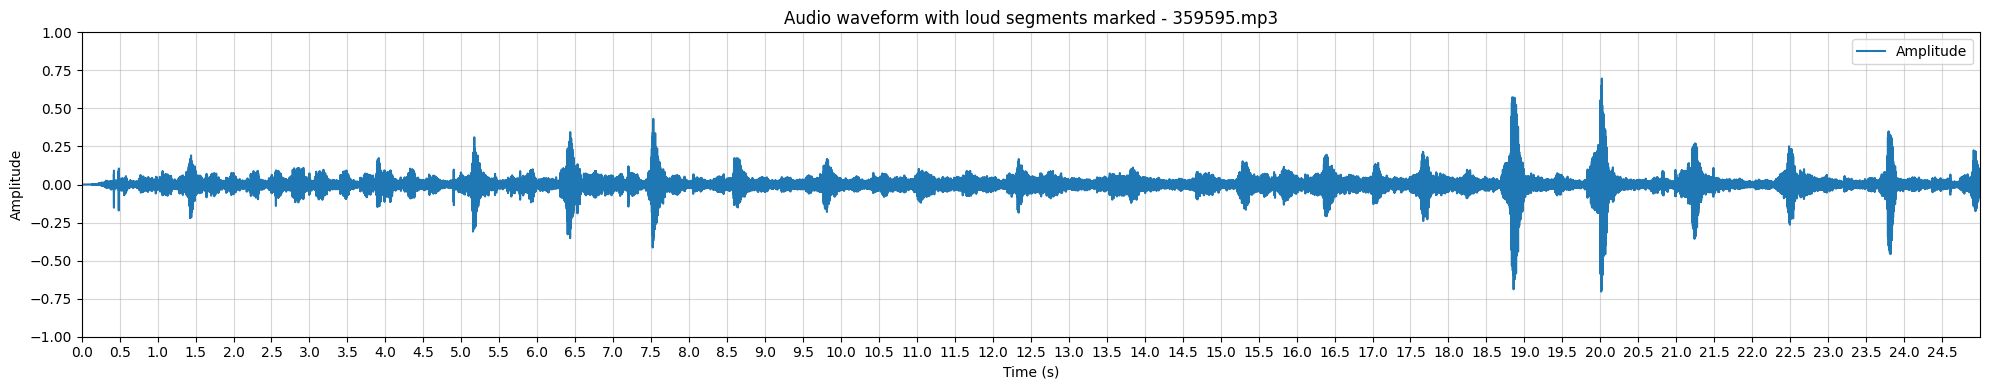

377589.mp3, []


KeyboardInterrupt: 

In [52]:
folder = f"{MAIN_PATH}/Dataset/xeno-canto"
# folder = f"{MAIN_PATH}/Dataset/noise-audio-data"
for file in os.listdir(folder):
    path = f"{folder}/{file}"
    result = main_pipeline(path)
    list_label = [data["timestamp"] for data in result if data["label"] == 0]
    print(f"{file}, {list_label}")
    load_and_plot(path, list_label, 25)